In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

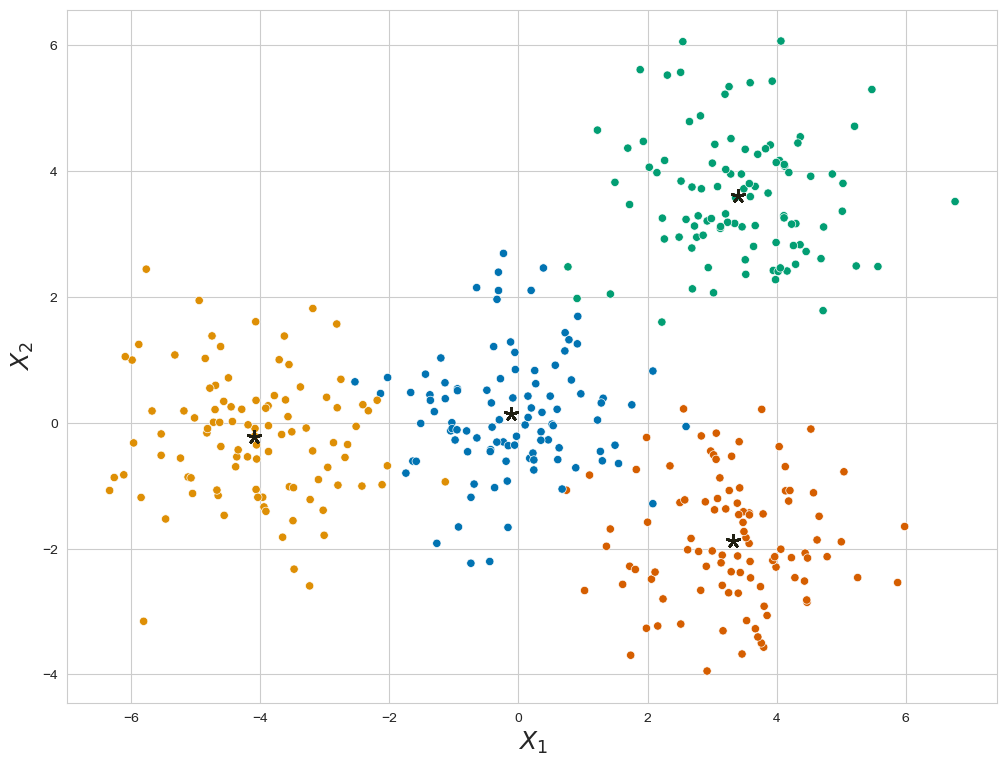

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)

        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        cluster_labels = None
        distances = self._calculate_distance(X, self.centroids)
        cluster_labels = np.argmin(np.array(distances), axis=0)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = None
        dist = np.linalg.norm((X - centroid), ord=2, axis=1).reshape(-1,1)

        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

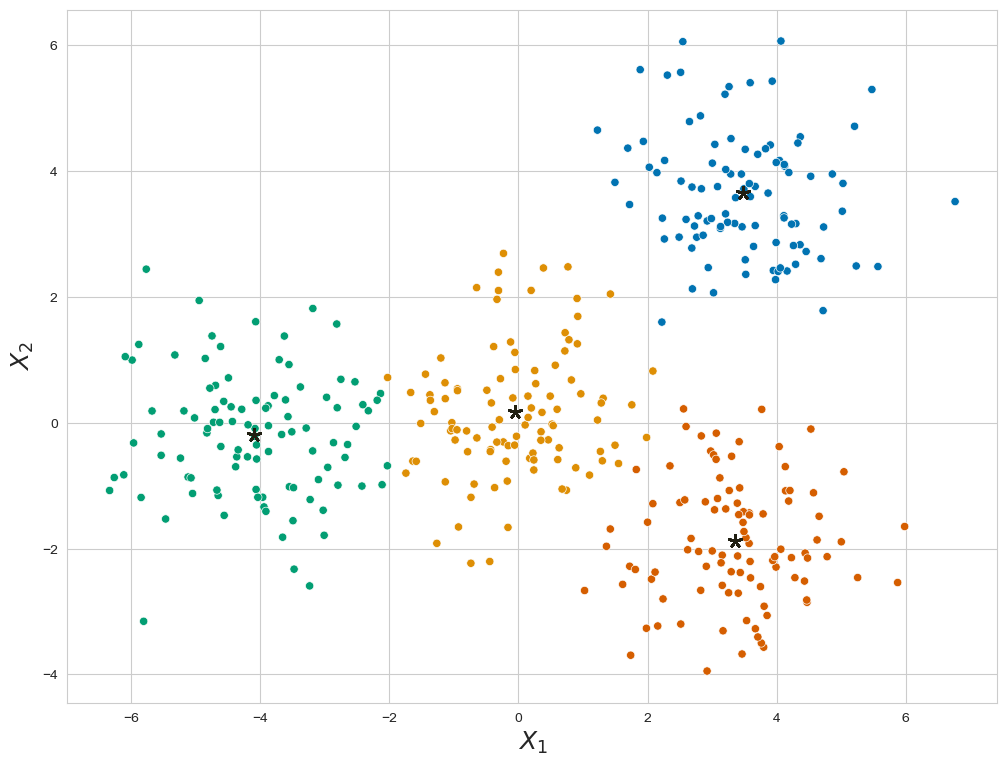

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
kmeans = MyKMeans(4, "random", max_iter=10, visualize=True)
kmeans.fit(X)

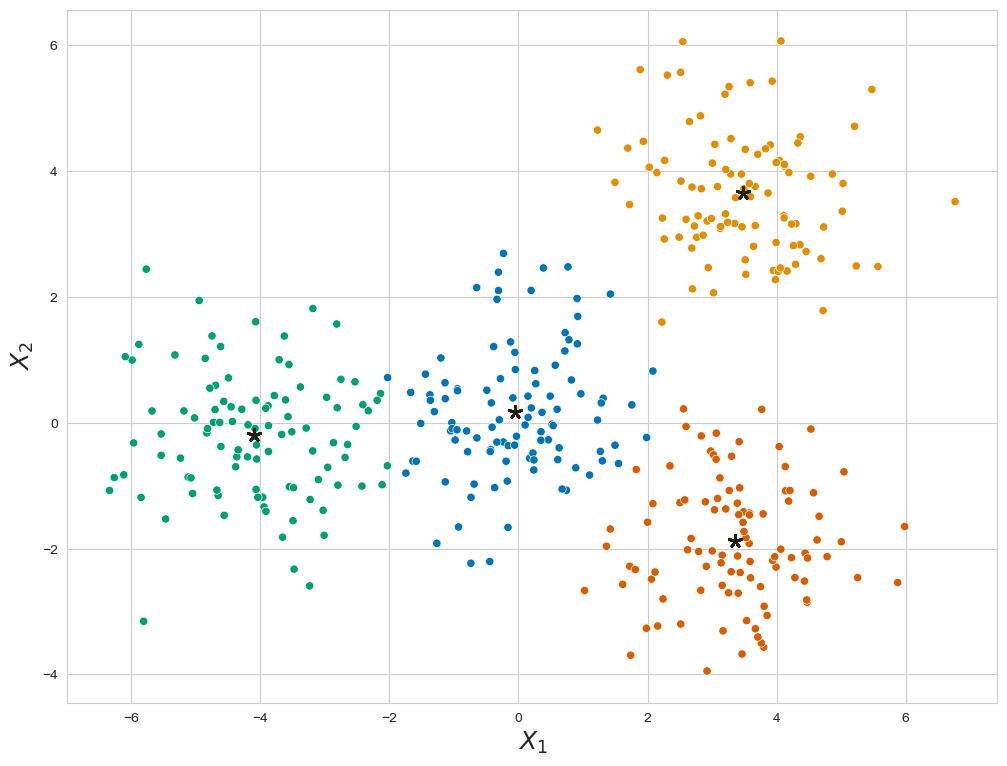

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
kmeans = MyKMeans(4, "sample", max_iter=10, visualize=True)
kmeans.fit(X)

В данной ситуации оба метода инициализации методов подошли

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target

In [10]:
X.shape

(1797, 64)

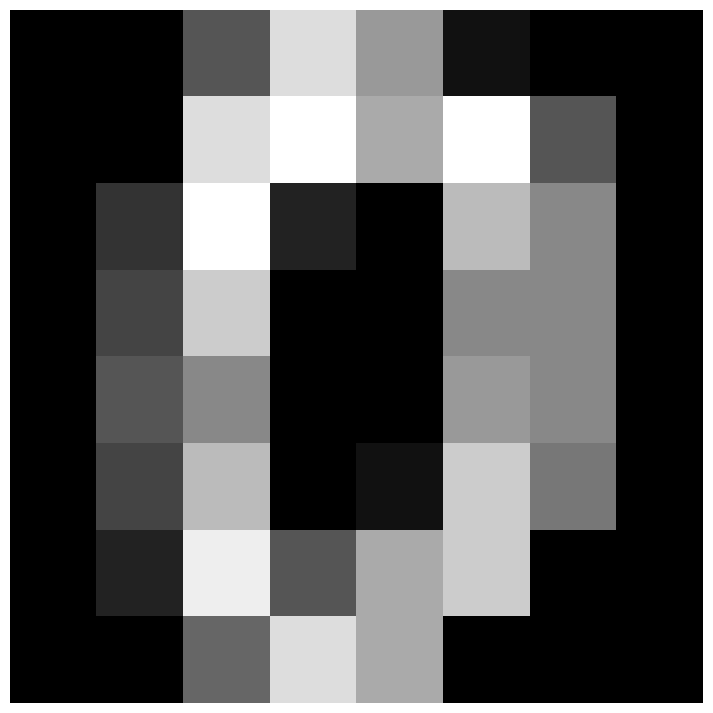

In [11]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [12]:
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, DBSCAN, OPTICS, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, v_measure_score, completeness_score
import pandas as pd

In [13]:
def get_supported_params(cluster_alg):
    # Fetch supported parameters for the clustering algorithm
    return list(cluster_alg().get_params().keys())

def algorithm_selection(X, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    compare_dataframe = pd.DataFrame()

    clustering = [AgglomerativeClustering,KMeans,OPTICS, Birch]
    clustering_name = ['AgglomerativeClustering','Kmeans','OPTICS', 'Birch']

    for cluster_alg, cluster_name in zip(clustering, clustering_name):
        supported_params = get_supported_params(cluster_alg)

        for distance in distances:
            for linkage in algorithms:
                # Check if n_clusters, distance, linkage are supported parameters
                params = {'n_clusters': 5, 'linkage': linkage, 'affinity': distance}
                params_for_algorithm = {}
                for param, value in params.items():
                    if param not in supported_params:
                        continue
                    else:
                        params_for_algorithm[param] = value
                # Run clustering model with current parameter set and add results to DataFrame
                model = cluster_alg(**params_for_algorithm)
                cluster_labels = model.fit_predict(X)

                homogeneity = metrics[0](y.ravel(), cluster_labels)
                completeness = metrics[1](y.ravel(), cluster_labels)
                v_measure = metrics[2](y.ravel(), cluster_labels)
                silhouette = metrics[3](X, cluster_labels)

                # Add results to DataFrame
                results = pd.Series([cluster_name, distance, linkage, homogeneity, completeness, v_measure, silhouette]).to_frame().T
                compare_dataframe = pd.concat([compare_dataframe, results], axis=0, ignore_index=True)
                
    return compare_dataframe


In [14]:
distances = ['chebyshev', 'manhattan', 'euclidean', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = [homogeneity_score, completeness_score, v_measure_score, silhouette_score]
result_df = algorithm_selection(X, distances=distances, algorithms=algorithms, metrics=metrics)

In [15]:
result_df = result_df.set_axis(['clustering_alg', 'distance','linkage','homogeneity', 'completeness', 'v_measure', 'silhouette'], axis=1)
result_df['total'] = result_df.iloc[:,3:].sum(axis=1)
result_df.sort_values(by='total',ascending=False)


clustering_alg   distance   linkage homogeneity completeness  \
47                    Birch     cosine  complete    0.593469     0.882403   
36                    Birch  chebyshev   average    0.593469     0.882403   
46                    Birch     cosine    single    0.593469     0.882403   
45                    Birch     cosine   average    0.593469     0.882403   
44                    Birch  euclidean  complete    0.593469     0.882403   
43                    Birch  euclidean    single    0.593469     0.882403   
42                    Birch  euclidean   average    0.593469     0.882403   
41                    Birch  manhattan  complete    0.593469     0.882403   
40                    Birch  manhattan    single    0.593469     0.882403   
39                    Birch  manhattan   average    0.593469     0.882403   
38                    Birch  chebyshev  complete    0.593469     0.882403   
37                    Birch  chebyshev    single    0.593469     0.882403   
0   AgglomerativeClustering  chebyshev   average    0.473193     0.867583   
3   AgglomerativeClustering  manhattan   average    0.469619     0.768695   
22                   Kmeans     cosine    single     0.48872     0.722351   
21                   Kmeans     cosine   average    0.486968     0.719961   
23                   Kmeans     cosine  complete    0.486929     0.719619   
12                   Kmeans  chebyshev   average    0.485826     0.718363   
13                   Kmeans  chebyshev    single    0.485577     0.718216   
19                   Kmeans  euclidean    single    0.485577     0.718216   
15                   Kmeans  manhattan   average    0.485631     0.717794   
16                   Kmeans  manhattan    single    0.485486     0.717678   
17                   Kmeans  manhattan  complete     0.48507     0.717267   
18                   Kmeans  euclidean   average    0.457925     0.698503   
9   AgglomerativeClustering     cosine   average    0.382869     0.819737   
14                   Kmeans  chebyshev  complete    0.453255     0.669299   
20                   Kmeans  euclidean  complete    0.450796     0.666015   
5   AgglomerativeClustering  manhattan  complete    0.418758     0.643104   
8   AgglomerativeClustering  euclidean  complete    0.426532     0.631284   
6   AgglomerativeClustering  euclidean   average    0.359987     0.675336   
11  AgglomerativeClustering     cosine  complete     0.39348     0.625386   
34                   OPTICS     cosine    single    0.283501     0.542562   
35                   OPTICS     cosine  complete    0.283501     0.542562   
30                   OPTICS  euclidean   average    0.283501     0.542562   
33                   OPTICS     cosine   average    0.283501     0.542562   
32                   OPTICS  euclidean  complete    0.283501     0.542562   
31                   OPTICS  euclidean    single    0.283501     0.542562   
29                   OPTICS  manhattan  complete    0.283501     0.542562   
28                   OPTICS  manhattan    single    0.283501     0.542562   
27                   OPTICS  manhattan   average    0.283501     0.542562   
26                   OPTICS  chebyshev  complete    0.283501     0.542562   
25                   OPTICS  chebyshev    single    0.283501     0.542562   
24                   OPTICS  chebyshev   average    0.283501     0.542562   
2   AgglomerativeClustering  chebyshev  complete    0.036485     0.445819   
1   AgglomerativeClustering  chebyshev    single    0.003336     0.289592   
10  AgglomerativeClustering     cosine    single    0.002245      0.27346   
4   AgglomerativeClustering  manhattan    single    0.002259     0.275133   
7   AgglomerativeClustering  euclidean    single    0.002259     0.275133   

   v_measure silhouette     total  
47  0.709654   0.118881  2.304407  
36  0.709654   0.118881  2.304407  
46  0.709654   0.118881  2.304407  
45  0.709654   0.118881  2.304407  
44  0.709654   0.118881  2.304407  
43  0.709654   0.118881

Я считал комбинации дистанций, линкаджа и метрик качества для разных алгоритмов кластеризации. Лучший оказался Birch с параметром n_clusters=5

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [16]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [17]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [18]:
fc_data.shape

(10000, 9)

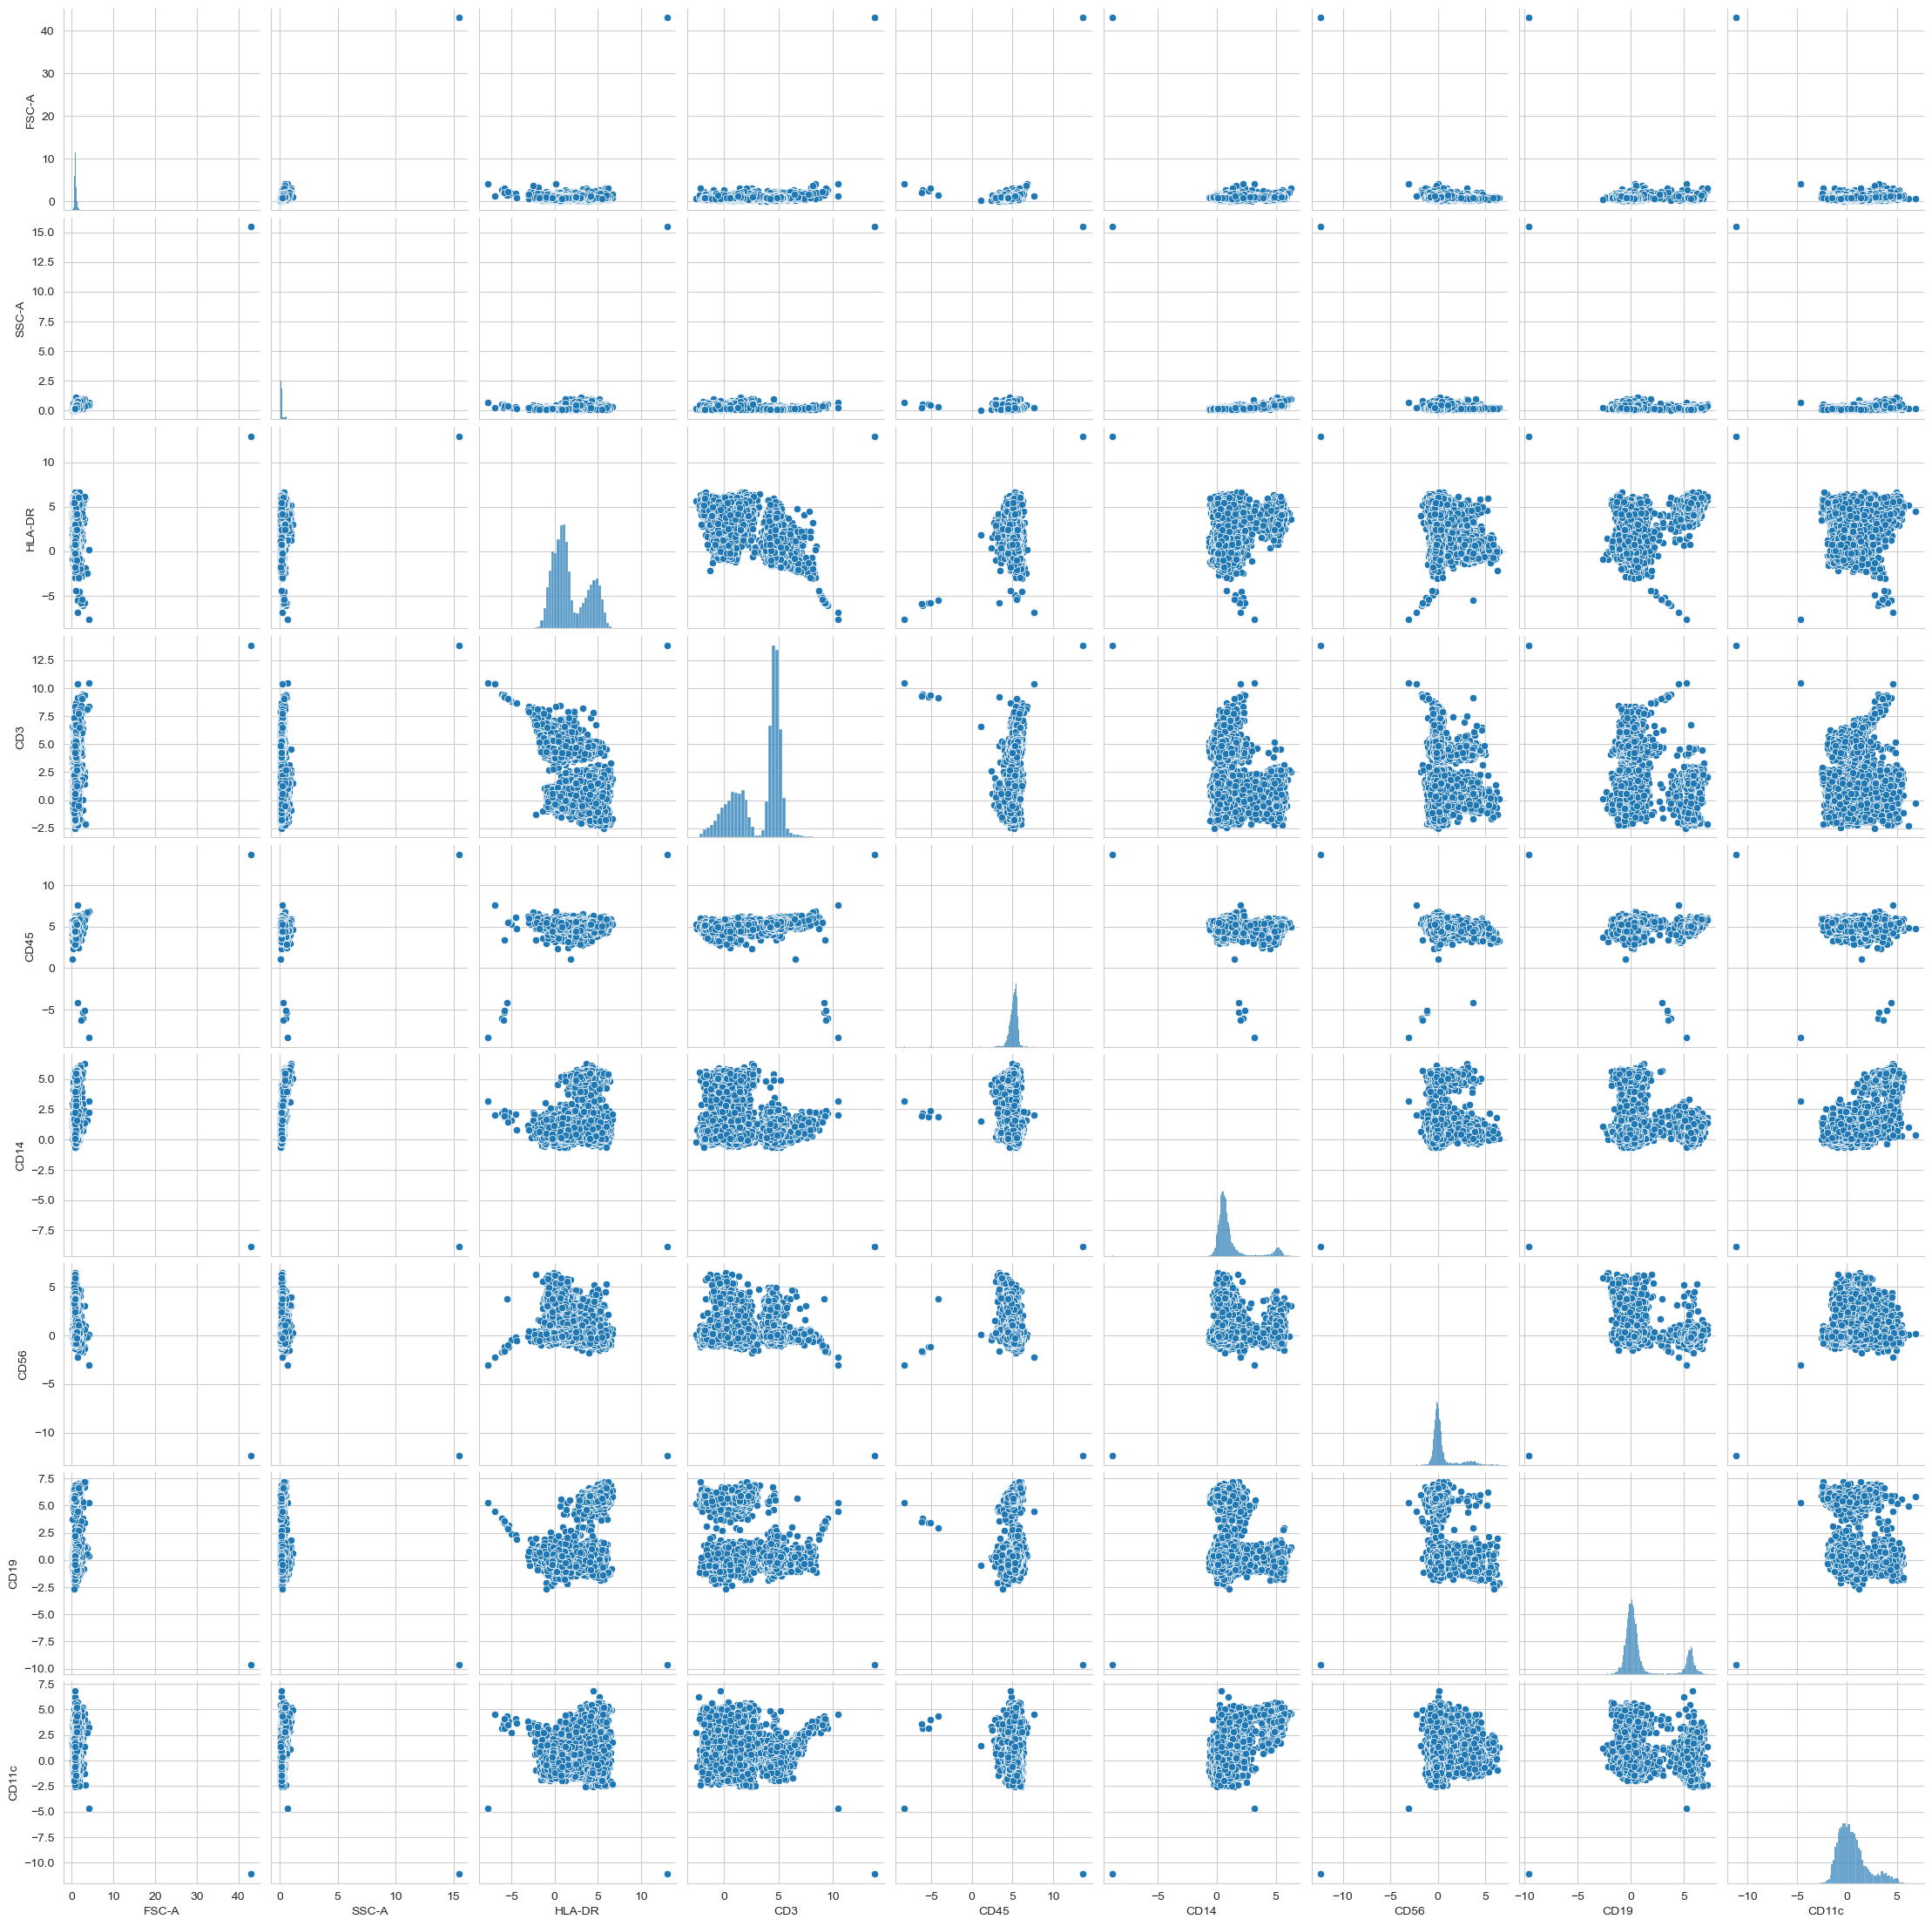

In [19]:
sns.pairplot(fc_data)

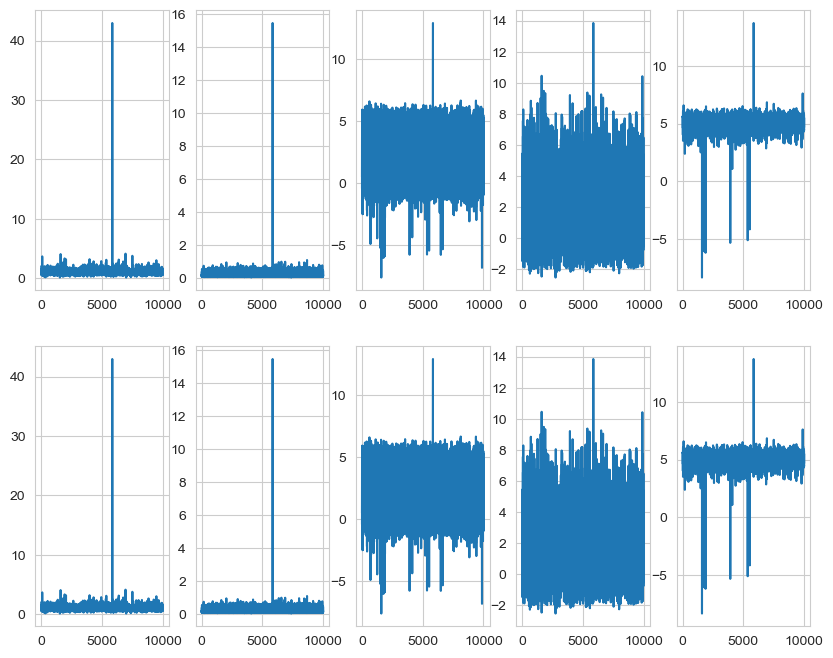

In [20]:
fig, axs = plt.subplots(2,5, figsize=(10,8))

for ax in axs:
    for i in range(len(ax.flatten())):
        ax[i].plot(fc_data.iloc[:,i])

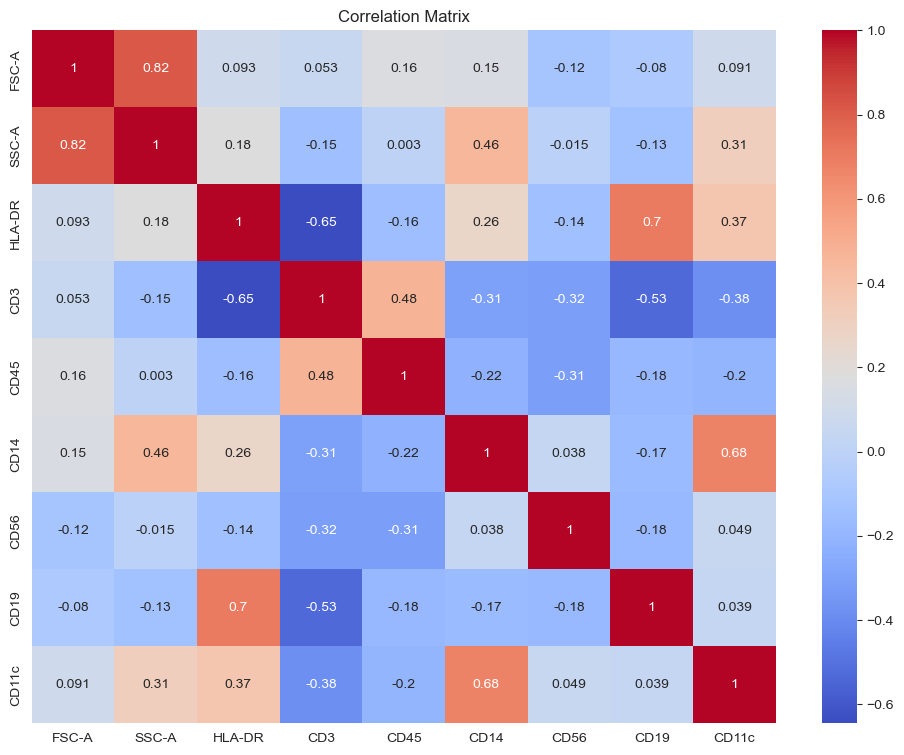

In [21]:
corr_matrix = fc_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [22]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

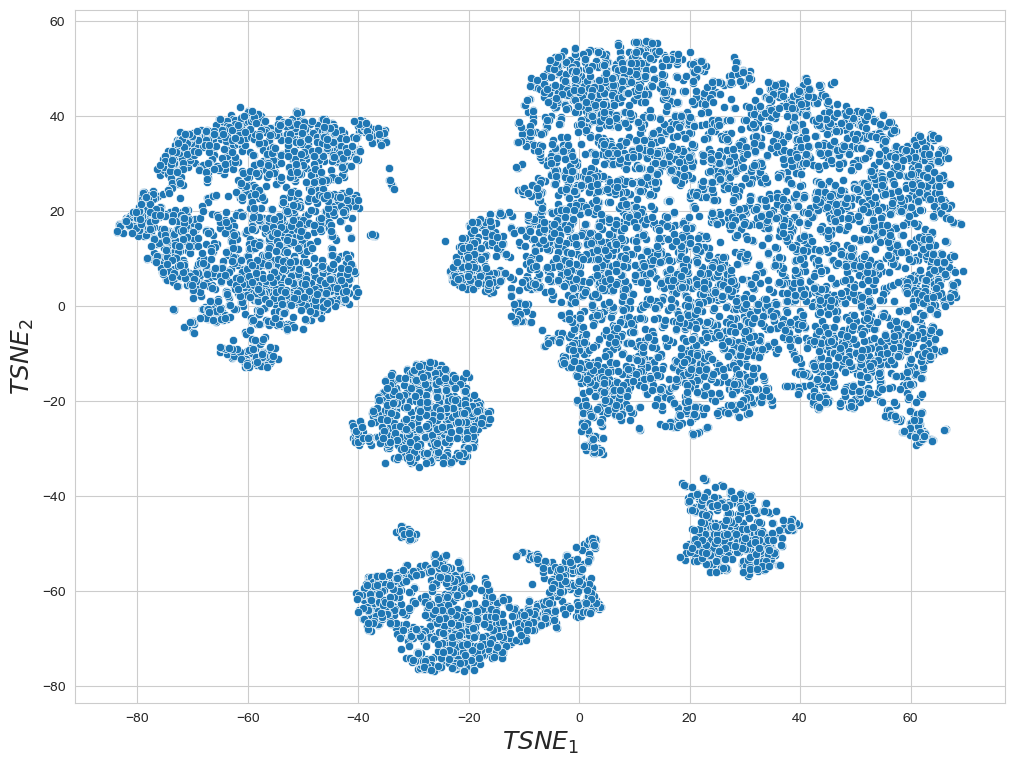

In [23]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [24]:
def get_supported_params(cluster_alg):
    # Fetch supported parameters for the clustering algorithm
    return list(cluster_alg().get_params().keys())

def algorithm_selection(X, distances, algorithms, metrics, number_of_clusters):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    compare_dataframe = pd.DataFrame()

    clustering = [AgglomerativeClustering,KMeans,OPTICS, Birch]
    clustering_name = ['AgglomerativeClustering','Kmeans','OPTICS', 'Birch']

    for cluster_alg, cluster_name in zip(clustering, clustering_name):
        supported_params = get_supported_params(cluster_alg)

        for distance in distances:
            for linkage in algorithms:
                for n_of_clusters in number_of_clusters:
                    # Check if n_clusters, distance, linkage are supported parameters
                    params = {'n_clusters': n_of_clusters, 'linkage': linkage, 'affinity': distance}
                    params_for_algorithm = {}
                    for param, value in params.items():
                        if param not in supported_params:
                            if param == 'linkage':
                                linkage = None
                            elif param == 'affinity':
                                distance = None
                            elif param == 'n_clusters':
                                distance = None
                        else:
                            params_for_algorithm[param] = value
                    # Run clustering model with current parameter set and add results to DataFrame
                    if linkage == 'ward':
                        if 'affinity' in params_for_algorithm.keys():
                            params_for_algorithm['affinity'] = 'euclidean'
                    model = cluster_alg(**params_for_algorithm)
                    cluster_labels = model.fit_predict(X)
                    silhouette = metrics[0](X, cluster_labels)

                    # Add results to DataFrame
                    results = pd.Series([cluster_name, n_of_clusters, distance, linkage, silhouette]).to_frame().T
                    compare_dataframe = pd.concat([compare_dataframe, results], axis=0, ignore_index=True)
                
    return compare_dataframe


In [25]:
distances = ['chebyshev', 'manhattan', 'euclidean', 'cosine']
algorithms = ['average', 'single', 'complete', 'ward']
metrics = [silhouette_score]
number_of_clusters = np.arange(2,7)
result_df = algorithm_selection(X, distances=distances, algorithms=algorithms, metrics=metrics, number_of_clusters=number_of_clusters)

In [26]:
result_df = result_df.set_axis(['clustering_alg', 'n_of_clusters','distance','linkage','silhouette'], axis=1)
result_df['total'] = result_df.iloc[:,4:].sum(axis=1)
result_df.sort_values(by='total',ascending=False)

clustering_alg n_of_clusters   distance linkage silhouette  \
5    AgglomerativeClustering             2  chebyshev  single   0.169015   
129                   Kmeans             6       None    None   0.151583   
159                   Kmeans             6       None    None   0.151578   
139                   Kmeans             6       None    None    0.15157   
89                    Kmeans             6       None    None   0.151553   
..                       ...           ...        ...     ...        ...   
213                   OPTICS             5       None    None  -0.200641   
214                   OPTICS             6       None    None  -0.200641   
215                   OPTICS             2       None    None  -0.200641   
216                   OPTICS             3       None    None  -0.200641   
160                   OPTICS             2       None    None  -0.200641   

        total  
5    0.169015  
129  0.151583  
159  0.151578  
139   0.15157  
89   0.151553  
..        ...  
213 -0.200641  
214 -0.200641  
215 -0.200641  
216 -0.200641  
160 -0.200641  

[320 rows x 6 columns]

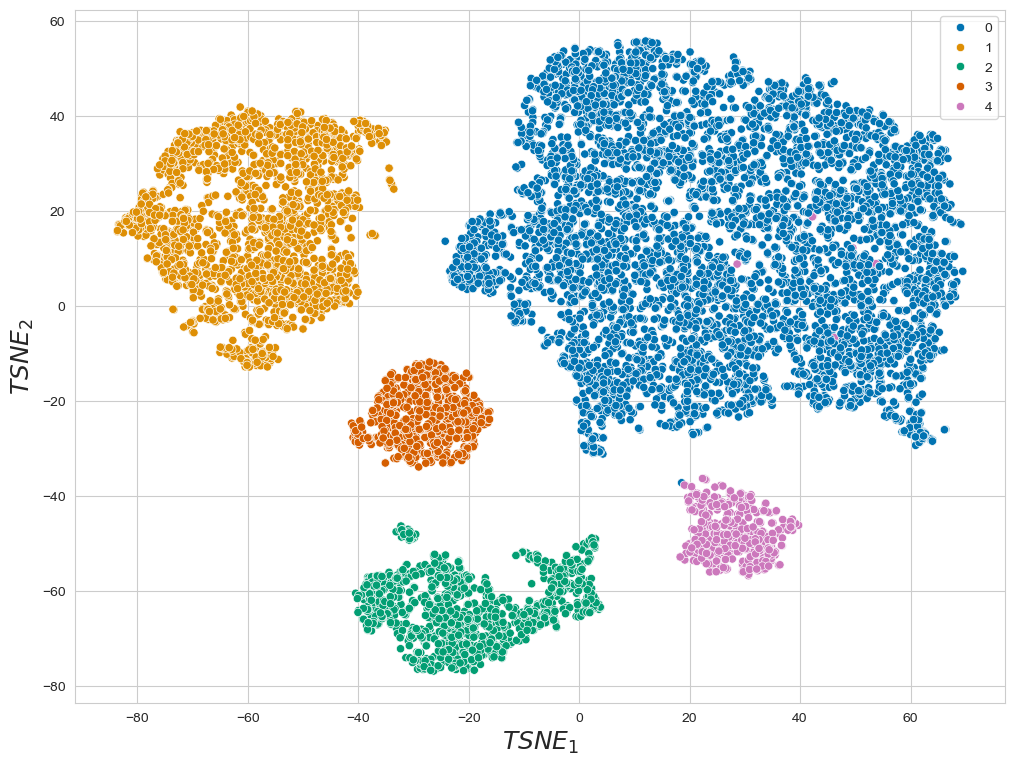

In [27]:
kmeans = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_labels = kmeans.fit_predict(fc_data)
tsne_res = plot_tsne(fc_data, color=cluster_labels)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

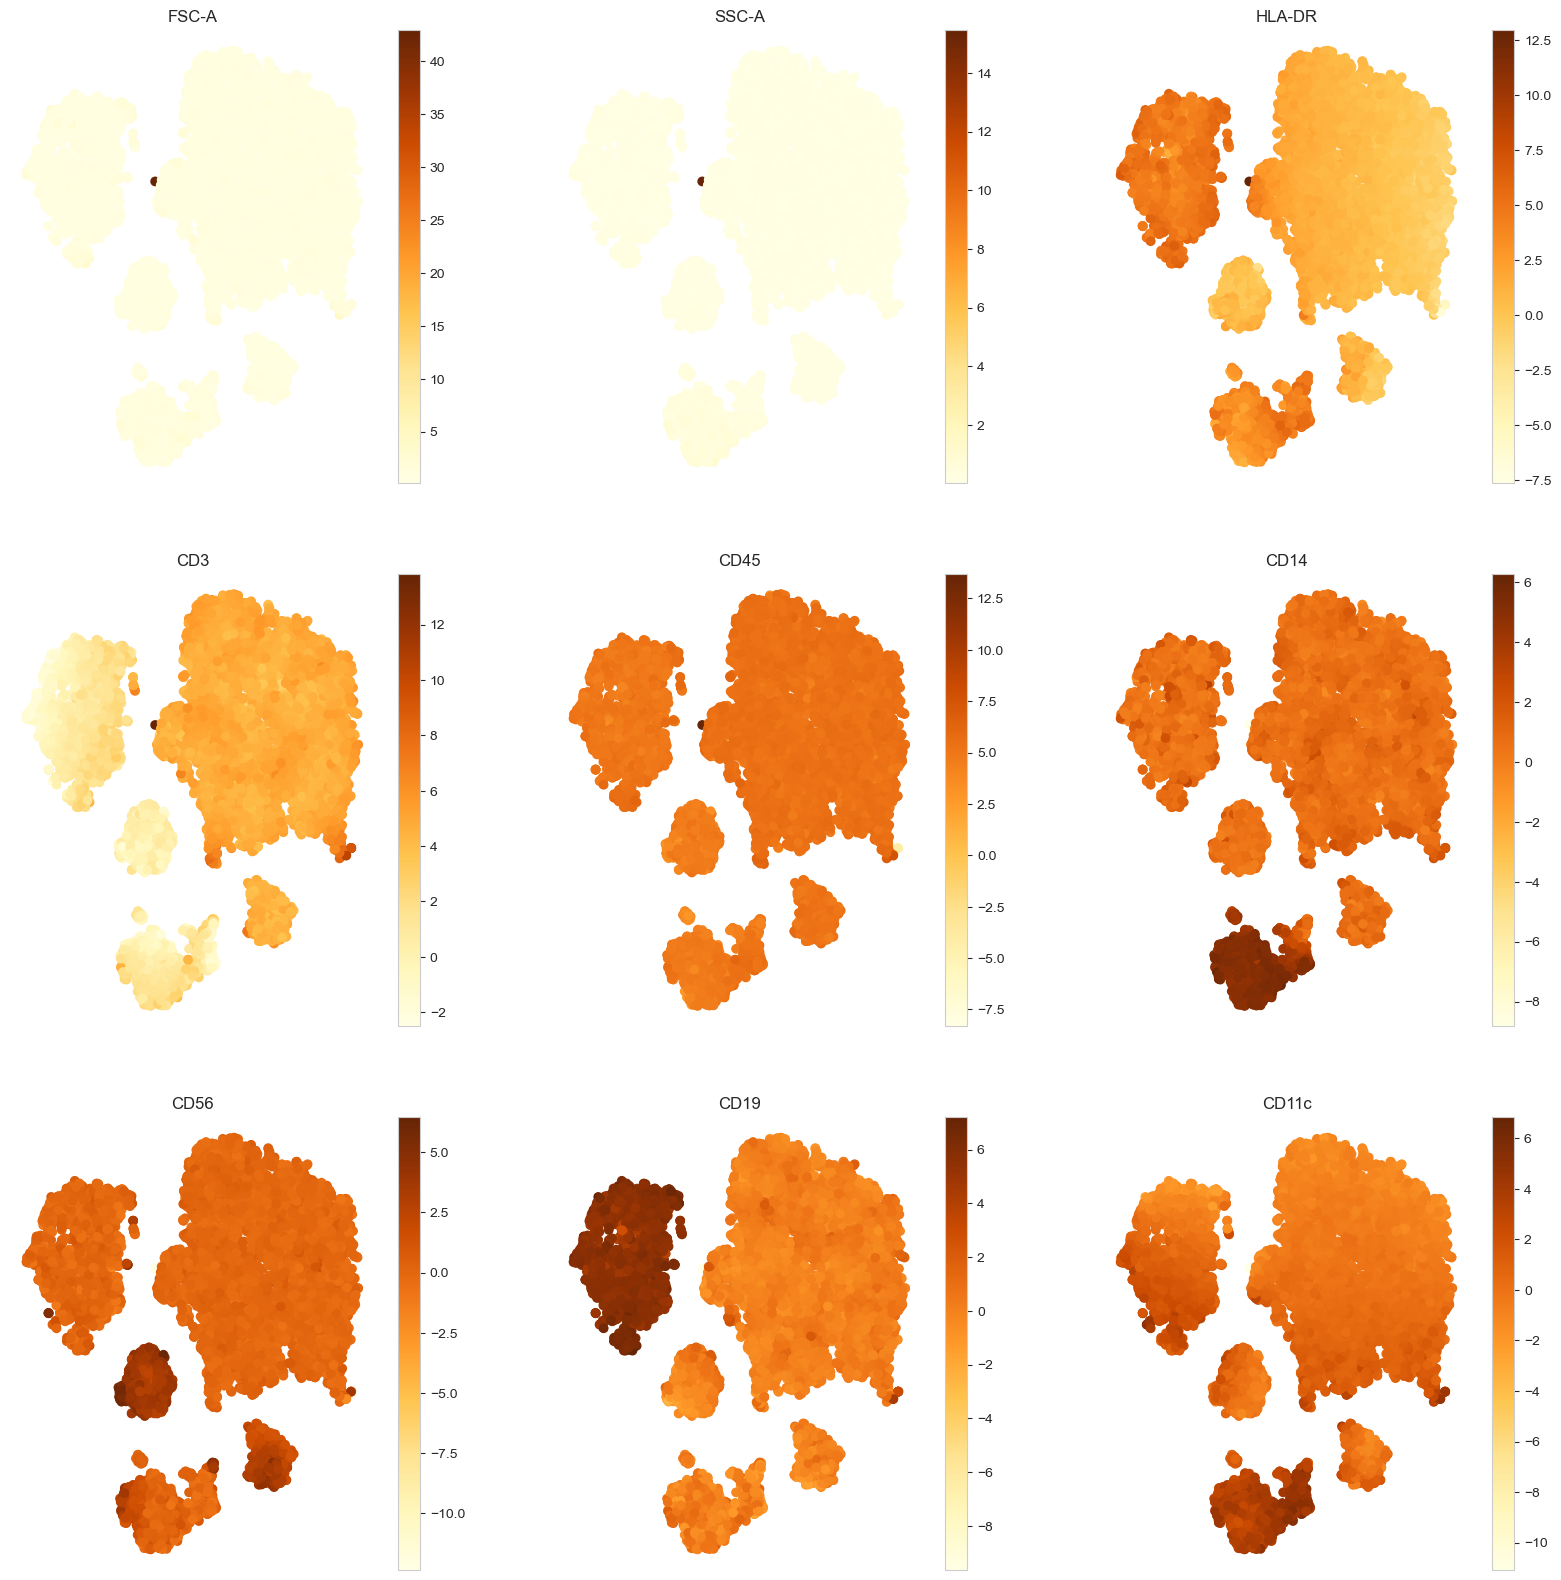

In [28]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [29]:
cell_type_cluster_map = {0: "T cells", 
                         1: "B cells", 
                         2: "Monocyte", 
                         3: "Other cells",
                         4: 'Other cells'}

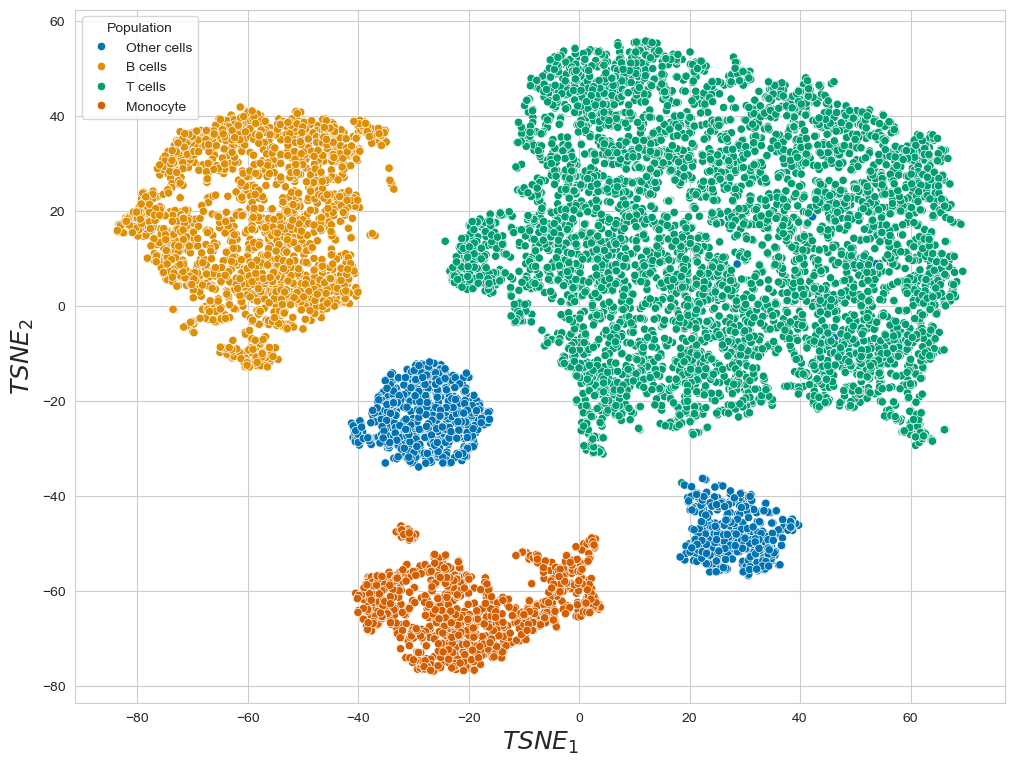

In [30]:
labeled_fc_data = fc_data.assign(Population=cluster_labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

tsne_res = plot_tsne(labeled_fc_data[labeled_fc_data.columns[labeled_fc_data.columns != 'Population']], color=labeled_fc_data['Population'])

Посчитайте, как распределены типы клеток:

In [31]:
labeled_fc_data['Population'].value_counts()

Population
T cells        5769
B cells        2035
Monocyte       1099
Other cells    1097
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [32]:
labeled_fc_data['Population'].to_csv('hw3_labels.csv', index=False, header=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [33]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
X, y = labeled_fc_data[labeled_fc_data.columns[labeled_fc_data.columns != 'Population']], labeled_fc_data['Population']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

print(f'Train f1: \n{classification_report(y_train, y_train_predict)}')
print(f'Test f1: \n{classification_report(y_test, y_test_predict)}')

Train f1: 
              precision    recall  f1-score   support

     B cells       1.00      1.00      1.00      1628
    Monocyte       0.99      1.00      1.00       879
 Other cells       0.99      0.98      0.99       878
     T cells       1.00      1.00      1.00      4615

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

Test f1: 
              precision    recall  f1-score   support

     B cells       1.00      1.00      1.00       407
    Monocyte       1.00      1.00      1.00       220
 Other cells       0.99      0.98      0.98       219
     T cells       1.00      1.00      1.00      1154

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

деревня писателей Переделкино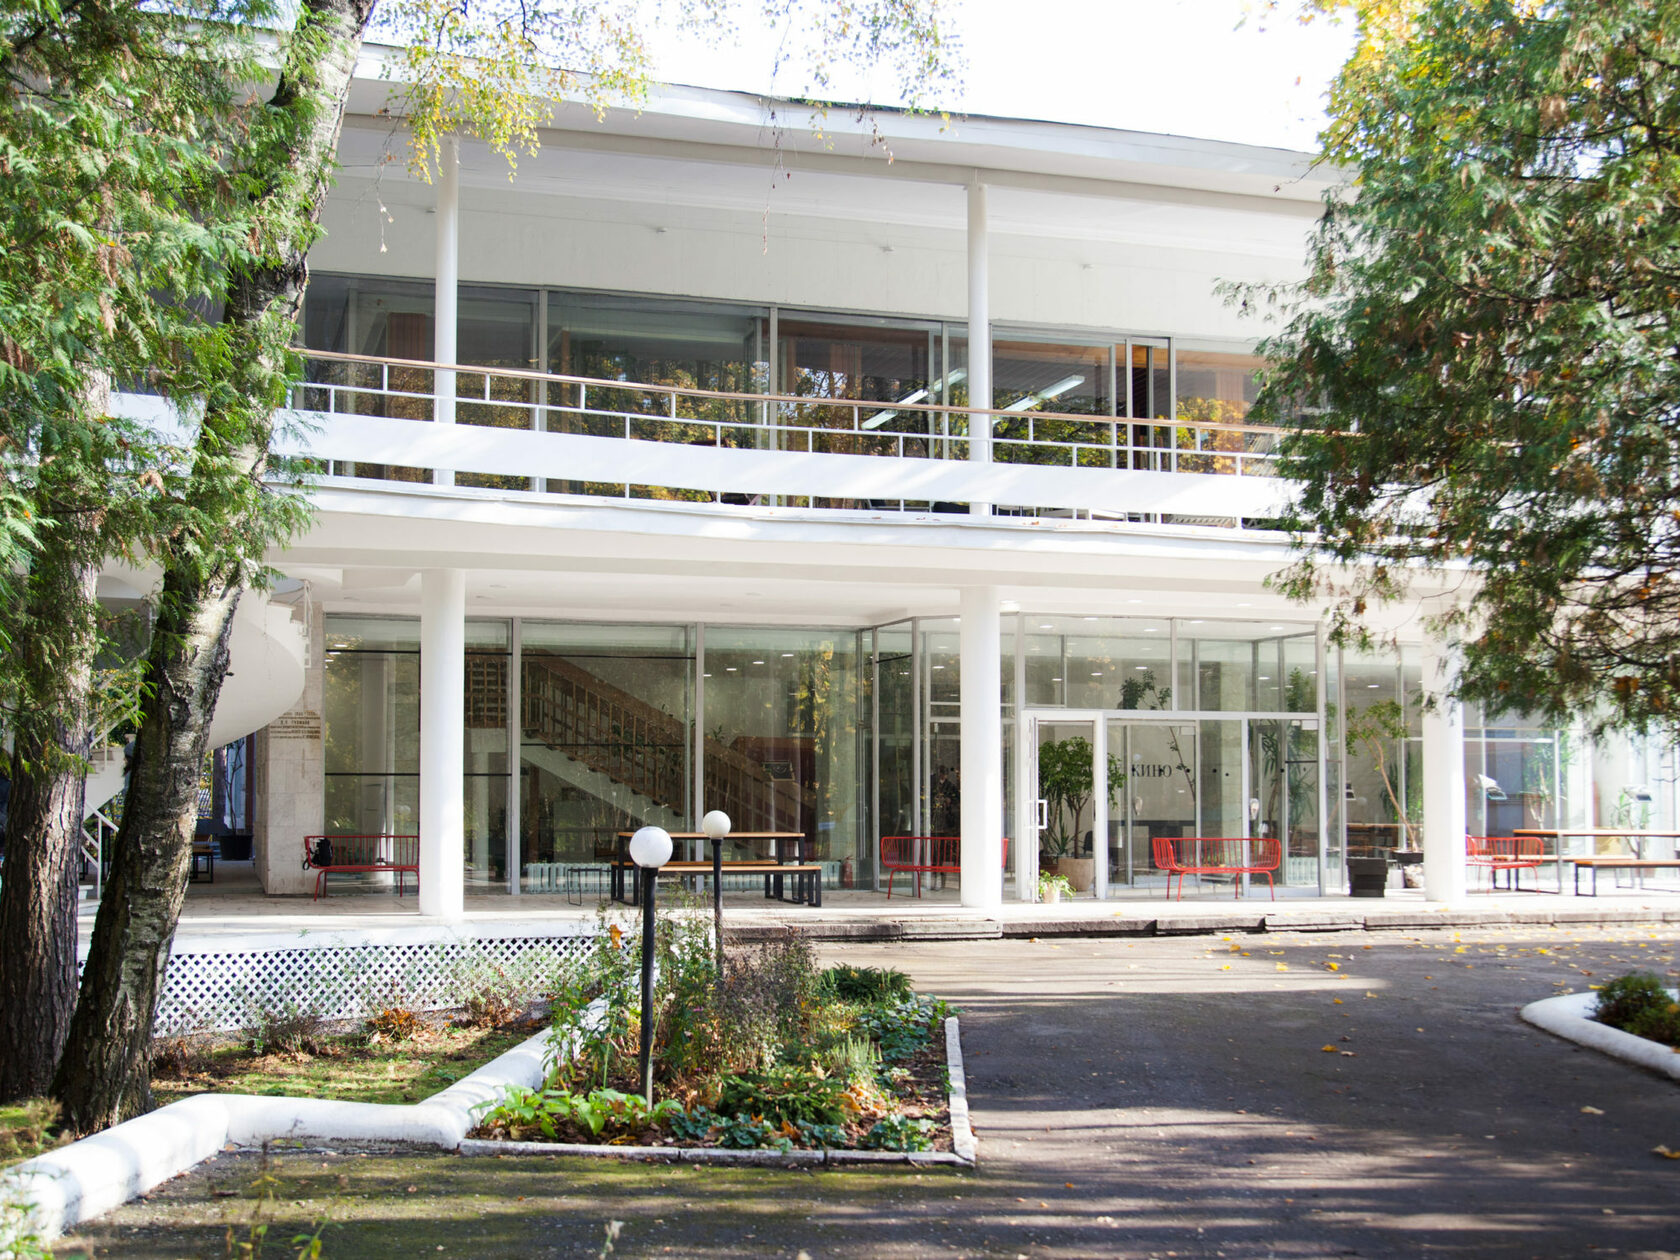

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Веселое задание! Правда код в начале падал(